# Performance Comparisons

We want to compare against several other packages on standard problems:

* GUDHI
* Dionysus
* Ripser
* TopologyLayer
* BATS standard with and without basis formation
* BATS clearing/compression optimizations (no basis)

Note TopologyLayer requires pytorch 1.1
```
conda install pytorch=1.1 -c pytorch
```

Dionysus and Gudhi can be installed via pip
```
pip install dionyusus gudhi
```

Write wrapper functions.  Take as input either two images or two metric spaces

In [1]:
import bats
import numpy as np
import matplotlib.pyplot as plt
import time
from freudenthal import freudenthal_grid

# Levelset Comparison

In [2]:
m = 200
n = 200

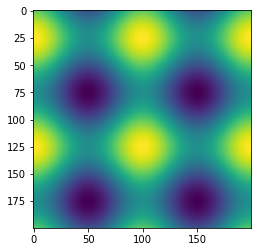

In [3]:
f = np.empty((m,n))
for i in range(m):
    for j in range(n):
        f[i,j] = np.sin(4*np.pi*i/m) + np.cos(4*np.pi*j/n)

f2 = f + 0.01*np.random.randn(m,n)
plt.imshow(f);

### BATS update:

In [28]:
def time_BATS_update(img, img2):
    m, n = img.shape
    X = freudenthal_grid(m, n)
    
    t0 = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, img.flatten())
    t1 = time.monotonic()
    print("time to extend: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F = bats.FilteredSimplicialComplex(X, vals)
    t1 = time.monotonic()
    print("time to construct: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R = bats.reduce(F, bats.F2())
    t1 = time.monotonic()
    print("time to reduce: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, img2.flatten())
    R.update_filtration(vals)
    t1 = time.monotonic()
    print("time to update: {} sec.".format(t1 - t0))
    
time_BATS_update(f, f2)

time to extend: 0.027576020002015866 sec.
time to construct: 0.05674107999948319 sec.
time to reduce: 0.9904755809984636 sec.
time to update: 0.1717016059992602 sec.


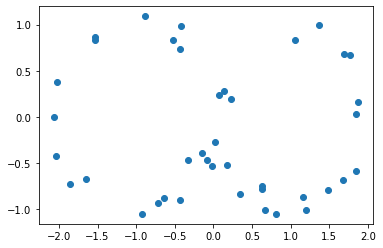

In [6]:
# first, generate two noisy circles
n = 40
Y = np.random.normal(size=(n,2))
Y = Y / np.linalg.norm(Y, axis=1).reshape(-1,1)
Y = Y + np.random.normal(size=(n,2), scale = 0.1 )

Y[:20,0] = Y[:20,0] - 1
Y[20:,0] = Y[20:,0] + 1
fig = plt.scatter(Y[:,0], Y[:,1])

Y2 = Y + 0.01*np.random.randn(n,2)

In [7]:
def time_BATS_update_rips(X, Y):
    dist = bats.Euclidean()  # distance we would like to use
    
    data = bats.DataSet(bats.Matrix(X)) # put into a bats.DataSet
    data_Y = bats.DataSet(bats.Matrix(Y)) # put into a bats.DataSet
    
    t0 = time.monotonic()
    F_X = bats.RipsFiltration(data, dist, np.inf, 2) # generate a RipsFiltration
    t1 = time.monotonic()
    print("time to construct: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R_X = bats.reduce(F_X, bats.F2()) # reduce with F2 coefficients
    t1 = time.monotonic()
    print("time to reduce: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F_Y = bats.RipsFiltration(data_Y, dist, np.inf, 2) # generate a RipsFiltration
    UI = bats.UpdateInfoFiltration(F_X, F_Y)
    R_X.update_filtration_general(UI)
    t1 = time.monotonic()
    print("time to update: {} sec.".format(t1 - t0))
    
time_BATS_update_rips(Y, Y2)

time to construct: 0.013148959995305631 sec.
time to reduce: 0.023266766998858657 sec.
time to update: 0.03398868099611718 sec.


### BATS with flags

In [40]:
def time_BATS_flags(img, img2, flags=(bats.standard_reduction_flag(), bats.compute_basis_flag())):
    m, n = img.shape
    X = freudenthal_grid(m, n)
    
    t0 = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, img.flatten())
    F = bats.FilteredSimplicialComplex(X, vals)
    R = bats.reduce(F, bats.F2(), *flags)
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, img2.flatten())
    F = bats.FilteredSimplicialComplex(X, vals)
    R = bats.reduce(F, bats.F2(), *flags)
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))
    
    
flags = [
    (bats.standard_reduction_flag(), bats.compute_basis_flag()),
    (bats.standard_reduction_flag(),),
    (bats.standard_reduction_flag(), bats.clearing_flag()),
    (bats.standard_reduction_flag(), bats.compression_flag()),
    (bats.extra_reduction_flag(), bats.compute_basis_flag()),
    (bats.extra_reduction_flag(),),
    (bats.extra_reduction_flag(), bats.clearing_flag()),
    (bats.extra_reduction_flag(), bats.compression_flag()),
]
labels = [
    "standard w/ basis",
    "standard w/ no basis",
    "standard w/ clearing",
    "standard w/ compression",
    "extra w/ basis",
    "extra w/ no basis",
    "extra w/ clearing",
    "extra w/ compression"
]
for flag, label in zip(flags, labels):
    print("\n{}:".format(label))
    time_BATS_flags(f, f2, flag)



standard w/ basis:
compute1: 0.8607918960042298 sec.
compute2: 0.9791247059911257 sec.

standard w/ no basis:
compute1: 0.25829882199468557 sec.
compute2: 0.31378373799088877 sec.

standard w/ clearing:
compute1: 0.13853270100662485 sec.
compute2: 0.20934674100135453 sec.

standard w/ compression:
compute1: 0.2590484319953248 sec.
compute2: 0.3215397539897822 sec.

extra w/ basis:
compute1: 0.7956855529919267 sec.
compute2: 0.9885522099939408 sec.

extra w/ no basis:
compute1: 0.25857965800969396 sec.
compute2: 0.3227293429954443 sec.

extra w/ clearing:
compute1: 0.14176227699499577 sec.
compute2: 0.23024295299546793 sec.

extra w/ compression:
compute1: 0.2634893549984554 sec.
compute2: 0.31142397900111973 sec.


### TopologyLayer:

In [1]:
from topologylayer.nn import LevelSetLayer2D
from topologylayer.nn import RipsLayer
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

In [6]:
m = 200
n = 200
f = np.empty((m,n))
for i in range(m):
    for j in range(n):
        f[i,j] = np.sin(4*np.pi*i/m) + np.cos(4*np.pi*j/n)

f2 = f + 0.01*np.random.randn(m,n)

In [7]:
def time_toplayer(img, img2):
    
    layer = LevelSetLayer2D(size=img.shape)
    img_t = torch.tensor(img, dtype=torch.float, requires_grad=False)
    img2_t = torch.tensor(img2, dtype=torch.float, requires_grad=False)
    
    t0 = time.monotonic()
    pds = layer(img_t)
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    pds = layer(img2_t)
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))

    
time_toplayer(f, f2)

compute1: 1.2029963829991175 sec.
compute2: 1.0349493460016674 sec.


#### Rips Complex

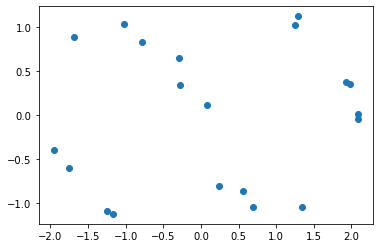

In [5]:
# first, generate two noisy circles
n = 20
Y = np.random.normal(size=(n,2))
Y = Y / np.linalg.norm(Y, axis=1).reshape(-1,1)
Y = Y + np.random.normal(size=(n,2), scale = 0.1 )

Y[:10,0] = Y[:10,0] - 1
Y[10:,0] = Y[10:,0] + 1
fig = plt.scatter(Y[:,0], Y[:,1])

Y2 = Y + 0.01*np.random.randn(n,2)

In [4]:
def time_toplayer_rips(y, y2):
    
    # layer = LevelSetLayer2D(size=img.shape)
    layer = RipsLayer(y.shape[0], maxdim=2)
    y_t = torch.tensor(y, dtype=torch.float, requires_grad=False)
    y2_t = torch.tensor(y2, dtype=torch.float, requires_grad=False)
    
    t0 = time.monotonic()
    pds = layer(y_t)
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    pds = layer(y2_t)
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))

    
time_toplayer_rips(Y, Y2)

compute1: 0.3466725820035208 sec.
compute2: 0.39421308699820656 sec.


Compared to TopologyLayer, BATs is much faster!!!! Rips Complex with 40 points in bats is faster than even 20 points in TopologyLayer!

### GUDHI: see http://gudhi.gforge.inria.fr/python/latest/simplex_tree_ref.html

In [8]:
import gudhi as gd

In [6]:
def construct_gudhi_simplex_tree(img):
    # create in BATS to dump
    X = freudenthal_grid(*img.shape)
    vals, imap = bats.lower_star_filtration(X, img.flatten())
    F = bats.FilteredSimplicialComplex(X, vals)
    
    t0 = time.monotonic()
    GT = gd.SimplexTree()
    for k in range(F.maxdim() + 1):
        for s, v in zip(X.get_simplices(k), F.vals(k)):
            GT.insert(s, v)
    t1 = time.monotonic()
    print("construction: {} sec.".format(t1 - t0))
    return GT

def update_gudhi_simplex_tree(tree, img):
    # create in BATS to dump
    X = freudenthal_grid(*img.shape)
    vals, imap = bats.lower_star_filtration(X, img.flatten())
    F = bats.FilteredSimplicialComplex(X, vals)
    
    t0 = time.monotonic()
    for k in range(F.maxdim() + 1):
        for s, v in zip(X.get_simplices(k), F.vals(k)):
            tree.assign_filtration(s, v)
    t1 = time.monotonic()
    print("update values: {} sec.".format(t1 - t0))
    return tree

def time_gudhi(img, img2):
    GT = construct_gudhi_simplex_tree(img)
    t0 = time.monotonic()
    diag = GT.persistence()
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    GT = update_gudhi_simplex_tree(GT, img2)
    t0 = time.monotonic()
    diag = GT.persistence()
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))
    
time_gudhi(f, f2)
    

construction: 0.21041526100452757 sec.
compute1: 0.15304399999877205 sec.
update values: 0.23118513300141785 sec.
compute2: 0.13194249499792932 sec.


It seems unnecessary for Gudhi to update simplex tree? (Need to write new python bindings for Updating information)

In [10]:
def time_gudhi_rips(X, Y):
    rips_complex = gd.RipsComplex(points=X, max_edge_length=np.inf)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    
    t0 = time.monotonic()
    diag = simplex_tree.persistence()
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    rips_complex = gd.RipsComplex(points=Y, max_edge_length=np.inf)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    
    t0 = time.monotonic()
    diag = simplex_tree.persistence()
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))
    
time_gudhi_rips(Y, Y2)

compute1: 0.0031279289978556335 sec.
compute2: 0.002779891001409851 sec.


Gudhi seems to have a good performance. 

### Dionysus: https://mrzv.org/software/dionysus2/tutorial/lower-star.html

In [8]:
import dionysus as d

ModuleNotFoundError: No module named 'dionysus'

In [38]:
def time_dionysus(img, img2):
    t0 = time.monotonic()
    f_lower_star = d.fill_freudenthal(img)
    t1 = time.monotonic()
    print("construction: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    p = d.homology_persistence(f_lower_star)
    dgms = d.init_diagrams(p, f_lower_star)
    t1 = time.monotonic()
    print("persistence: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    f_lower_star = d.fill_freudenthal(img2)
    t1 = time.monotonic()
    print("construction: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    p = d.homology_persistence(f_lower_star)
    dgms = d.init_diagrams(p, f_lower_star)
    t1 = time.monotonic()
    print("persistence: {} sec.".format(t1 - t0))
    
time_dionysus(f, f2)

construction: 0.16443070200330112 sec.
persistence: 0.1521793869906105 sec.
construction: 0.21891731600044295 sec.
persistence: 0.1651727970020147 sec.
